In [1]:
import datetime as dt
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("Datos/Transformados/dow_jones_clean.csv", index_col=0)
df = df[['CRM', 'PG', 'DIS']]

# Calcular rentabilidad diaria
for ticker in df.columns:
    df[ticker + '_Return'] = 100 * df[ticker].pct_change()
df.dropna(inplace=True)

df.head()

,CRM,PG,DIS,CRM_Return,PG_Return,DIS_Return
2018-06-07,131.526474,62.769722,98.018539,-1.947620,1.896454,0.549499
2018-06-08,132.139999,63.946251,99.462944,0.466465,1.874357,1.473603
2018-06-11,132.585312,64.236229,99.816872,0.337001,0.453472,0.355839
2018-06-12,134.841568,63.995949,99.797745,1.701739,-0.374057,-0.019162
2018-06-13,135.079086,63.357986,101.691734,0.176146,-0.996879,1.897828


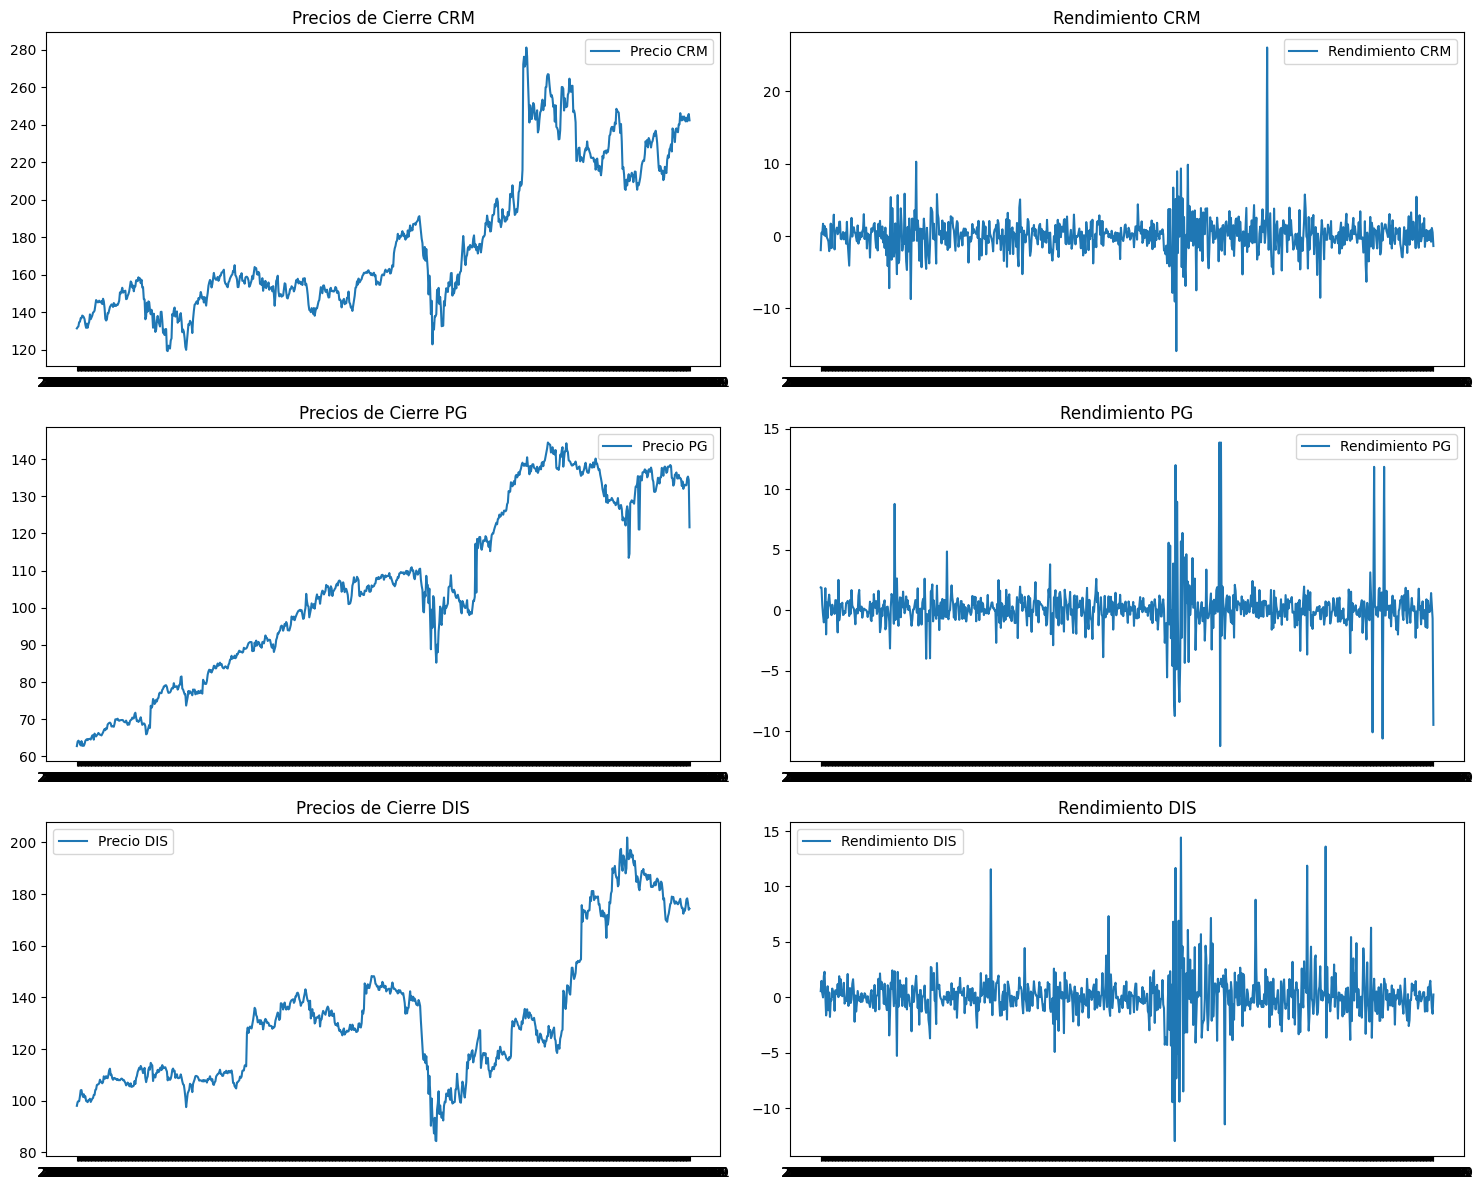

In [3]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))

for i, ticker in enumerate(['CRM', 'PG', 'DIS']):
    ax[i, 0].plot(df[ticker], label=f"Precio {ticker}")
    ax[i, 0].set_title(f"Precios de Cierre {ticker}")
    ax[i, 0].legend()

    ax[i, 1].plot(df[ticker + '_Return'], label=f"Rendimiento {ticker}")
    ax[i, 1].set_title(f"Rendimiento {ticker}")
    ax[i, 1].legend()

plt.tight_layout()
plt.show()


In [10]:
lm_test

(np.float64(103.73490510356949),
 np.float64(9.721854793288347e-18),
 11.78141353358199,
 4.768653922842171e-19)

In [14]:
for ticker in ['CRM', 'PG', 'DIS']:
    print(f"\nTests para {ticker}")
    print("ADF p-valor:", adfuller(df[ticker + '_Return'])[1])
    print("KPSS p-valor:", kpss(df[ticker + '_Return'])[1])

    lm_test = het_arch(df[ticker + '_Return'])
    print("ARCH test LM p-valor F:", lm_test[3])



Tests para CRM
ADF p-valor: 7.604718360559439e-16
KPSS p-valor: 0.1
ARCH test LM p-valor F: 0.09853882298321108

Tests para PG
ADF p-valor: 2.185535401921227e-11
KPSS p-valor: 0.1
ARCH test LM p-valor F: 1.934591004321948e-58

Tests para DIS
ADF p-valor: 1.0845448523594733e-14
KPSS p-valor: 0.1
ARCH test LM p-valor F: 4.768653922842171e-19


C:\Users\danie\AppData\Local\Temp\ipykernel_11676\2141281968.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS p-valor:", kpss(df[ticker + '_Return'])[1])
C:\Users\danie\AppData\Local\Temp\ipykernel_11676\2141281968.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS p-valor:", kpss(df[ticker + '_Return'])[1])
C:\Users\danie\AppData\Local\Temp\ipykernel_11676\2141281968.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS p-valor:", kpss(df[ticker + '_Return'])[1])


In [ ]:
# Fijándonos en los tests de ADF y KPSS, las tres rentabilidades de los activos son estacionarios. Sin embargo, los activos de PG y DIS presentan heterocedasticidad.

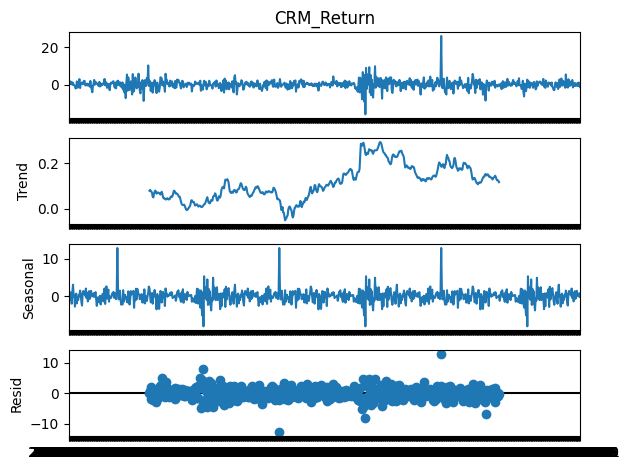

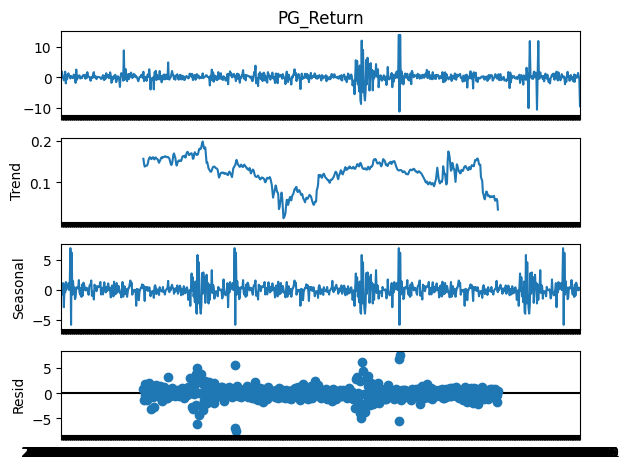

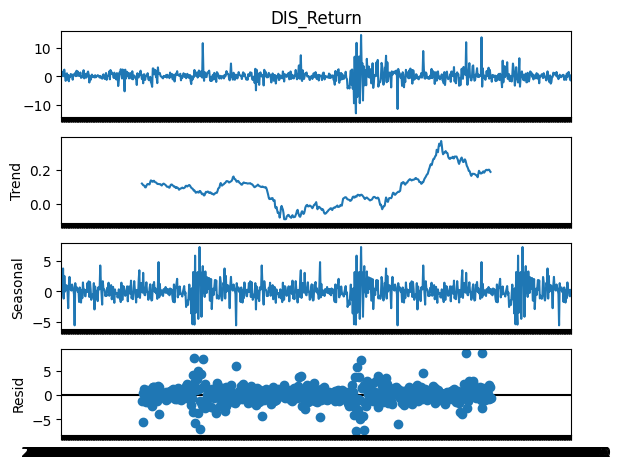

In [16]:
for ticker in ['CRM', 'PG', 'DIS']:
    result = seasonal_decompose(df[ticker + '_Return'], model='additive', period=252)
    result.plot()
    plt.show()


En principio, no se observa ningún patrón evitende en el rendimiento de la serie por lo que trabajaremos directamente con la variable.

Dibujamos los diagramas de autocorrelación y autocorrelación parcial del rendimiento al cuadrado.

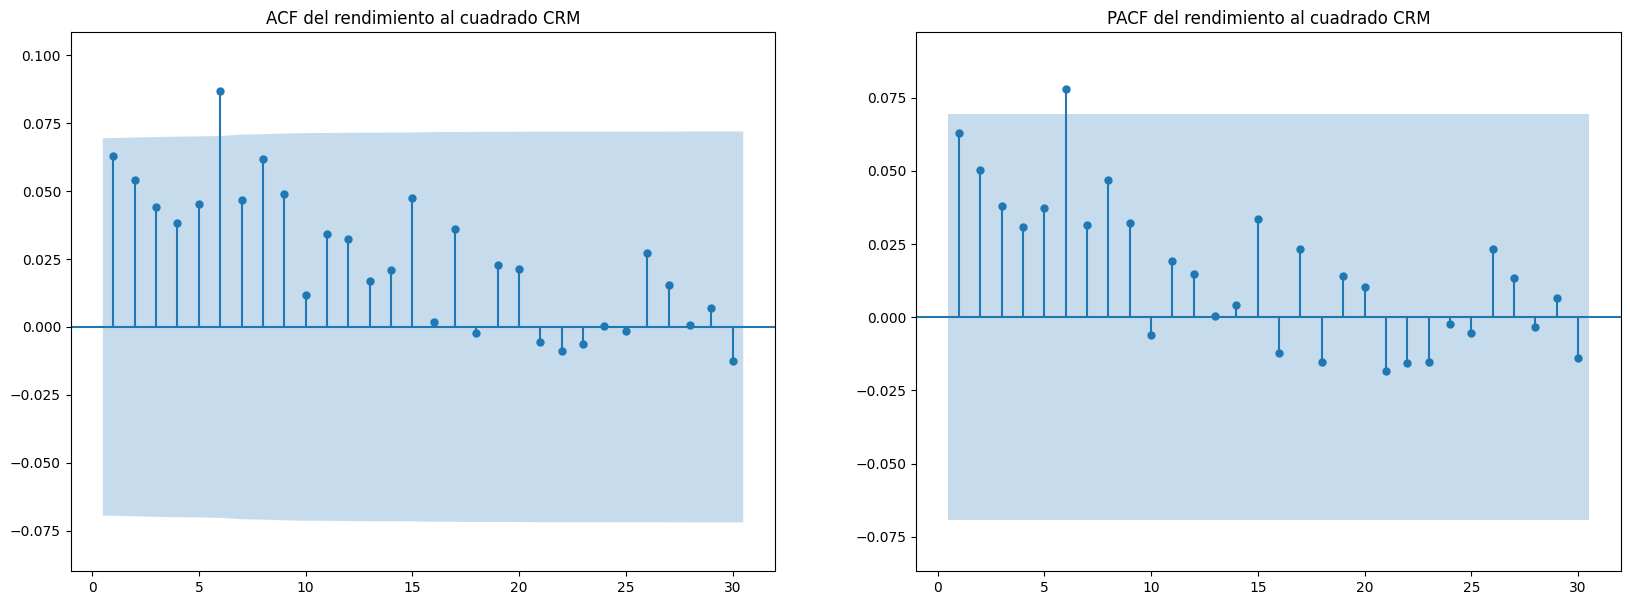

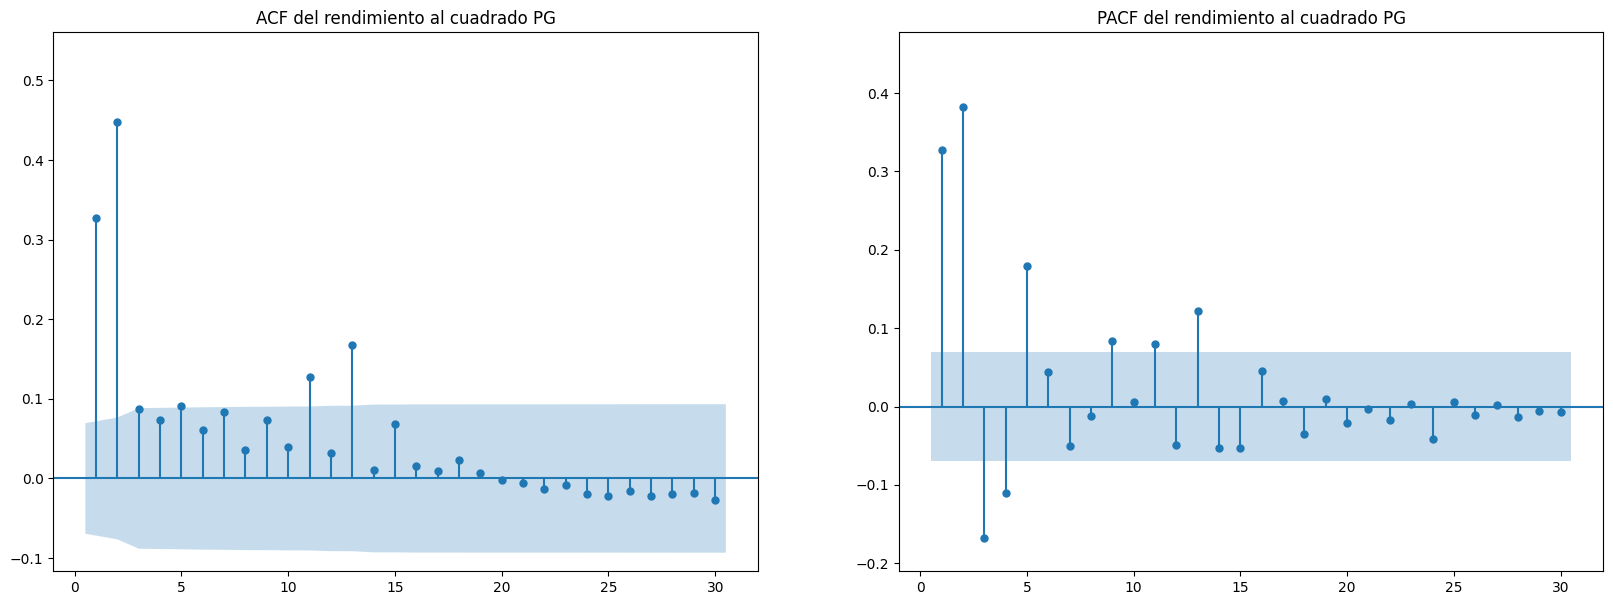

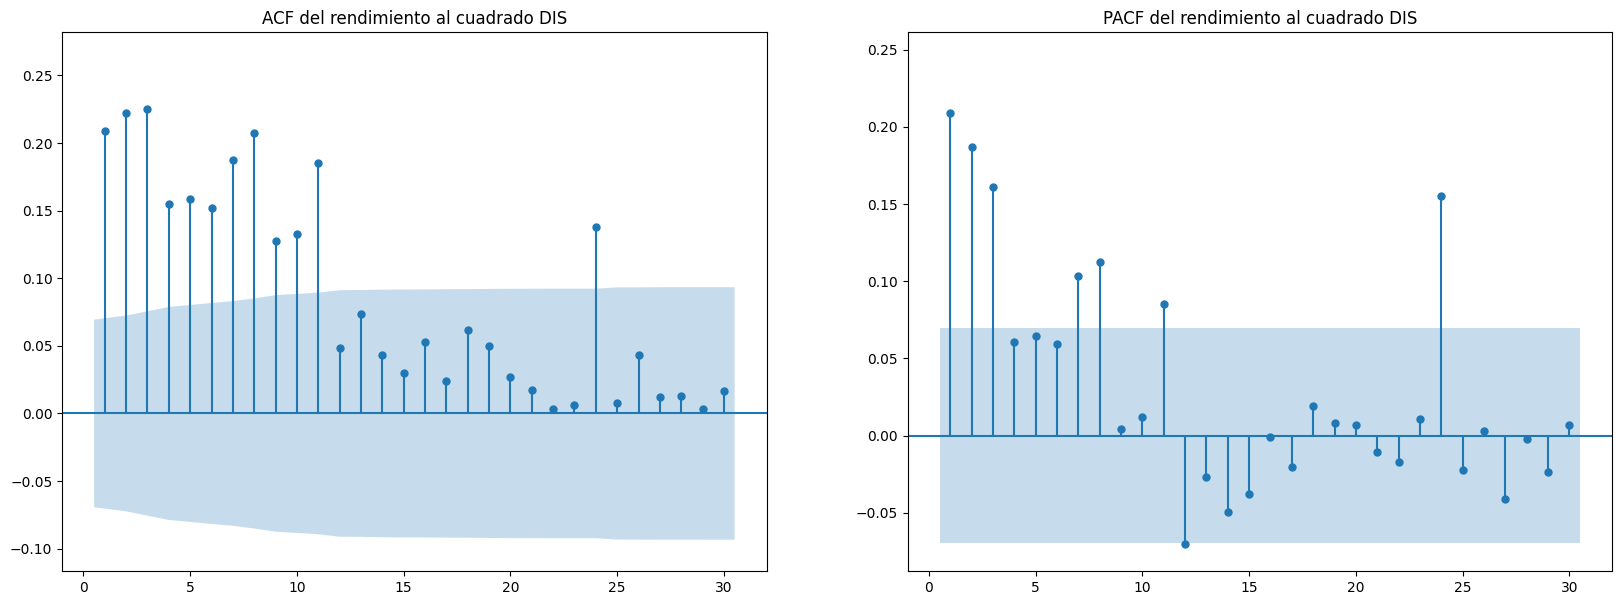

In [17]:
plt.rcParams["figure.figsize"] = (20, 7)

for ticker in ['CRM', 'PG', 'DIS']:
    rent2 = df[ticker + '_Return'].mul(df[ticker + '_Return'])
    fig, ax = plt.subplots(1, 2)
    sgt.plot_acf(rent2, ax=ax[0], zero=False, auto_ylims=True, title=f"ACF del rendimiento al cuadrado {ticker}")
    sgt.plot_pacf(rent2, ax=ax[1], zero=False, auto_ylims=True, title=f"PACF del rendimiento al cuadrado {ticker}")
    plt.show()


In [23]:
from arch import arch_model

def seleccionar_mejor_modelo(serie, modelos):
    resultados = []
    for m in modelos:
        try:
            res = arch_model(serie, **m).fit(disp='off')
            resultados.append((res.aic, res.bic, res))
        except:
            continue
    # Elige el modelo con menor AIC o BIC
    mejor = min(resultados, key=lambda tup: (tup[1], tup[0])) # Prioriza BIC, luego AIC
    return mejor[2]
    
modelos_prueba = [
    dict(vol='Garch', p=1, q=1, mean='constant'),
    dict(vol='Garch', p=2, q=1, mean='constant'),
    dict(vol='Garch', p=1, q=2, mean='constant'),
    dict(vol='EGARCH', p=1, q=1, mean='constant'),
]
mejor_pg = seleccionar_mejor_modelo(df['PG_Return'], modelos_prueba)
mejor_dis = seleccionar_mejor_modelo(df['DIS_Return'], modelos_prueba)
mejor_crm = seleccionar_mejor_modelo(df['CRM_Return'], modelos_prueba)

print(mejor_pg.summary())
print(mejor_dis.summary())
print(mejor_crm.summary())


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              PG_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1393.67
Distribution:                  Normal   AIC:                           2795.34
Method:            Maximum Likelihood   BIC:                           2814.06
                                        No. Observations:                  797
Date:               ju., oct. 09 2025   Df Residuals:                      796
Time:                        12:49:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0508  4.311e-02      1.178      0.239 [-3.37

In [25]:
mejor_pg

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              PG_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1393.67
Distribution:                  Normal   AIC:                           2795.34
Method:            Maximum Likelihood   BIC:                           2814.06
                                        No. Observations:                  797
Date:               ju., oct. 09 2025   Df Residuals:                      796
Time:                        12:49:29   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0508  4.311e-02      1.178      0.239 [-3.37

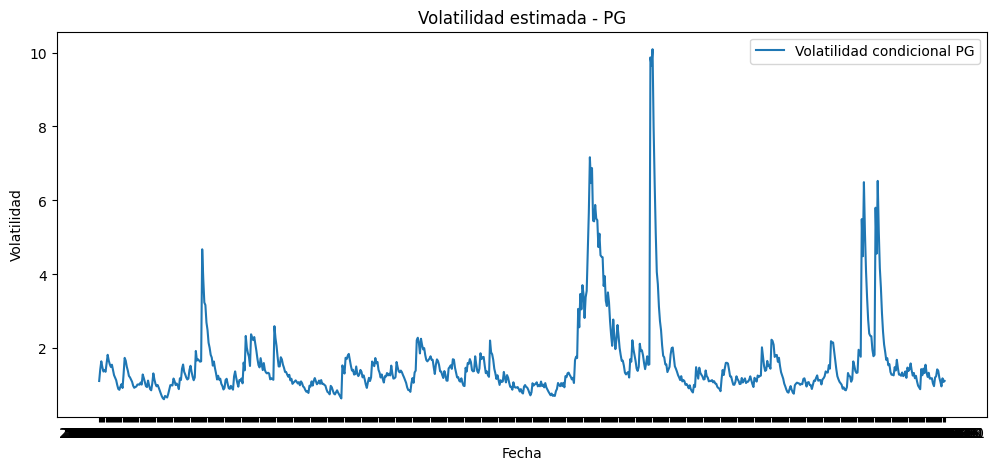

ValueError: Analytic forecasts not available for horizon > 1

In [24]:
import matplotlib.pyplot as plt

# Para cada activo, suponiendo que tienes el modelo ajustado en res_activo
for activo, res in zip(['PG', 'DIS', 'CRM'], [mejor_pg, mejor_dis, mejor_crm]):
    # Extrae la serie de volatilidad condicional estimada (desviación estándar)
    volatilidad = res.conditional_volatility
    plt.figure(figsize=(12,5))
    plt.plot(volatilidad, label=f'Volatilidad condicional {activo}')
    plt.title(f'Volatilidad estimada - {activo}')
    plt.xlabel('Fecha')
    plt.ylabel('Volatilidad')
    plt.legend()
    plt.show()

    # Predicción de volatilidad futuros (por ejemplo, 10 días)
    forecasts = res.forecast(horizon=10)
    forecast_vol = forecasts.variance.values[-1, :]
    print(f'Pronóstico de volatilidad próxima para {activo}:')
    print(forecast_vol)



Forecast de volatilidad para CRM


c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered

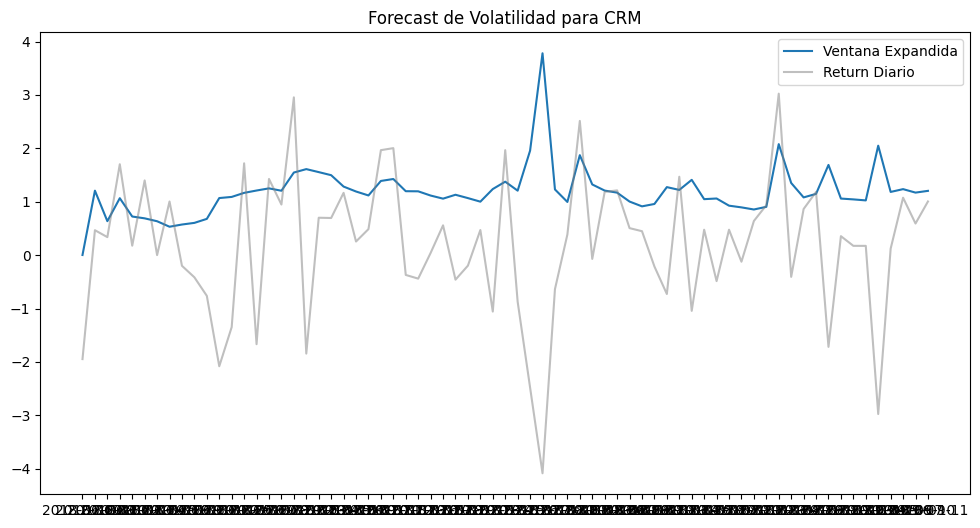


Forecast de volatilidad para PG


c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered

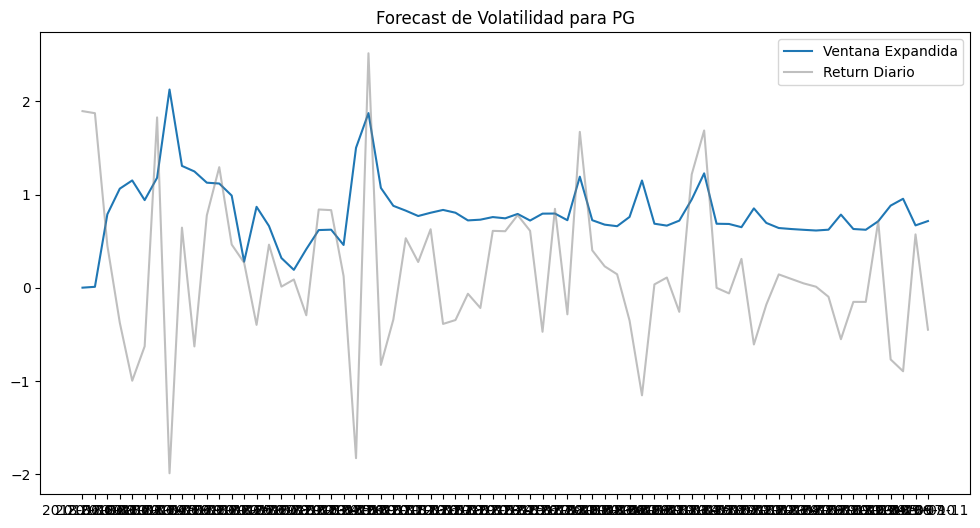


Forecast de volatilidad para DIS


c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\danie\anaconda3\envs\Amarillo_R9\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered

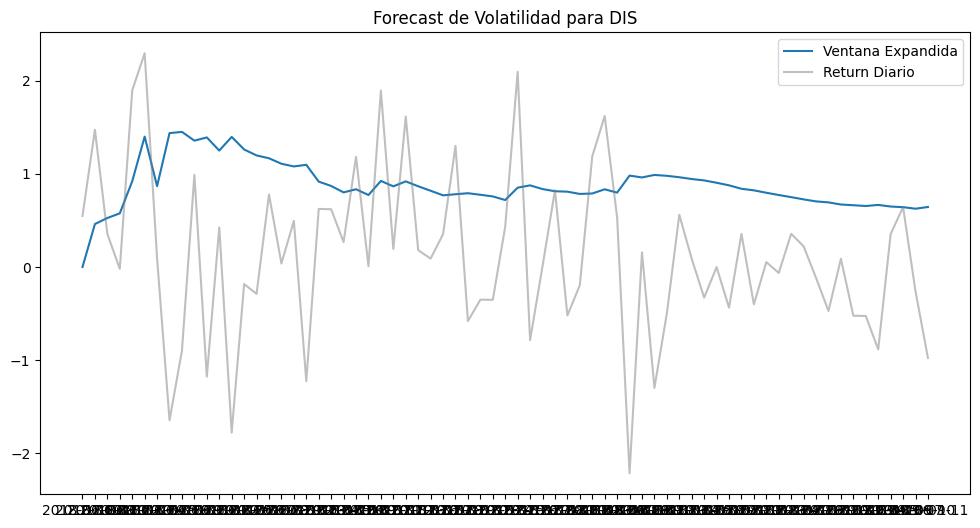

In [20]:
for ticker in ['CRM', 'PG', 'DIS']:
    print(f"\nForecast de volatilidad para {ticker}")

    index = df.index[::-1]  # invertir orden del índice para que 0 sea dato más antiguo
    start = 0
    end = np.where(index >= '2021-01-01')[0].min()

    # Forecast con ventana expandida
    forecasts_exp = {}
    for i in range(70):
        last_obs = i + end
        if last_obs <= start:
            continue
        modelo = arch_model(df[ticker + '_Return'], p=1, q=1, mean='constant', vol='Garch', dist='normal')
        res = modelo.fit(first_obs=start, last_obs=last_obs, disp='off')
        temp = res.forecast(horizon=1, reindex=True).variance
        fc = temp.iloc[last_obs - 1]
        forecasts_exp[fc.name] = fc
    pred_var_exp = pd.DataFrame(forecasts_exp).T

    # Forecast con ventana fija
    forecasts_fix = {}
    for i in range(70):
        first_obs = start + i
        last_obs = i + end
        if last_obs <= first_obs:
            continue
        modelo = arch_model(df[ticker + '_Return'], p=1, q=1, mean='constant', vol='Garch', dist='normal')
        res = modelo.fit(first_obs=first_obs, last_obs=last_obs, disp='off')
        temp = res.forecast(horizon=1, reindex=True).variance
        fc = temp.iloc[last_obs - 1]
        forecasts_fix[fc.name] = fc
    pred_var_fix = pd.DataFrame(forecasts_fix).T

    # Calcular volatilidad (raíz de la varianza)
    pred_vol_exp = np.sqrt(pred_var_exp)
    pred_vol_fix = np.sqrt(pred_var_fix)

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(pred_vol_exp, label='Ventana Expandida')
    plt.plot(pred_vol_fix, label='Ventana Fija')
    plt.plot(df[ticker + '_Return'].loc[pred_var_exp.index], label='Return Diario', color='grey', alpha=0.5)
    plt.title(f"Forecast de Volatilidad para {ticker}")
    plt.legend()
    plt.show()


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(observed, forecast):
    # Alinear índices comunes
    common_idx = observed.index.intersection(forecast.index)
    observed_aligned = observed.loc[common_idx]
    forecast_aligned = forecast.loc[common_idx]

    mae = mean_absolute_error(observed_aligned, forecast_aligned)
    mse = mean_squared_error(observed_aligned, forecast_aligned)
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")
    return mae, mse

for ticker in ['CRM', 'PG', 'DIS']:
    vol = df[ticker + '_Return'].sub(df[ticker + '_Return'].mean()).pow(2)[pred_var_exp.index]
    print(f"Evaluación para {ticker} - Ventana Expandida")
    evaluate(vol, pred_vol_exp[ticker])
    
    if not pred_vol_fix.empty and ticker in pred_vol_fix.columns:
        print(f"Evaluación para {ticker} - Ventana Fija")
        evaluate(vol, pred_vol_fix[ticker])
    else:
        print(f"No hay datos para ventana fija de {ticker}")


Evaluación para CRM - Ventana Expandida


KeyError: 'CRM'